# Description of the breast lesion deep learning project

## Motivation and notes

## Publications data sources

Al-Dhabyani, W., Gomaa, M., Khaled, H., & Fahmy, A. (2019). Dataset of breast ultrasound images. Data in brief, 28, 104863. https://doi.org/10.1016/j.dib.2019.104863

Pawłowska, A., Ćwierz-Pieńkowska, A., Domalik, A., Jaguś, D., Kasprzak, P., Matkowski, R., Fura, Ł., Nowicki, A., & Zolek, N. (2024). A Curated Benchmark Dataset for Ultrasound Based Breast Lesion Analysis (Breast-Lesions-USG) (Version 1) [dataset]. The Cancer Imaging Archive. https://doi.org/10.7937/9WKK-Q141

**the following data is not included yet**

A. Abbasian Ardakani, A. Mohammadi, M. Mirza-Aghazadeh-Attari, U.R. Acharya, An open-access breast lesion ultrasound image database‏: Applicable in artificial intelligence studies, Computers in Biology and Medicine, 152 (2023) 106438. https://doi.org/10.1016/j.compbiomed.2022.106438



In [2]:
url4 = "https://qamebi.com/wp-content/uploads/2022/11/Benign.zip" #image, mask and masked image file .bmp files?
url5 = "https://qamebi.com/wp-content/uploads/2022/11/Malignant.zip"

# Loading and organizing data

In [5]:
import os
import shutil
import requests
from zipfile import ZipFile
from tqdm import tqdm


In [56]:
url1 = "https://scholar.cu.edu.eg/Dataset_BUSI.zip"
url2 = "https://www.cancerimagingarchive.net/wp-content/uploads/BrEaST-Lesions_USG-images_and_masks-Dec-15-2023.zip"
url3 = "https://www.cancerimagingarchive.net/wp-content/uploads/BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx"
data_dir = "data"

os.makedirs(data_dir, exist_ok=True)  # only created if does not exist

response1 = requests.get(url1, stream=True, verify=False)
zip_file_path1 = os.path.join(data_dir, "Dataset_BUSI.zip")
with open(zip_file_path1, "wb") as zip_file:
    total_size = int(response1.headers.get('content-length', 0))
    with tqdm(total=total_size, unit='B', unit_scale=True, desc=os.path.basename(zip_file_path1)) as pbar:
        for data in response1.iter_content(chunk_size=1024):
            pbar.update(len(data))
            zip_file.write(data)

with ZipFile(zip_file_path1, "r") as zip_ref:
    zip_ref.extractall(data_dir)

# put images into one directory
target_directory = os.path.join(data_dir, "Dataset_BUSI_with_GT")
os.makedirs(target_directory, exist_ok=True)
source_extracted_folder = os.path.join(data_dir, "Dataset_BUSI_with_GT")
categories = ['benign', 'malignant', 'normal']
for category in categories:
    subfolder_path = os.path.join(source_extracted_folder, category)
    for file in os.listdir(subfolder_path):
        src_path = os.path.join(subfolder_path, file)
        dest_path = os.path.join(target_directory, file)
        shutil.move(src_path, dest_path)
    os.rmdir(subfolder_path)

os.remove(zip_file_path1)

response2 = requests.get(url2, stream=True, verify=False)
zip_file_path2 = os.path.join(data_dir, "BrEaST-Lesions_USG-images_and_masks-Dec-15-2023.zip")
with open(zip_file_path2, "wb") as zip_file:
    total_size = int(response2.headers.get('content-length', 0))
    with tqdm(total=total_size, unit='B', unit_scale=True, desc=os.path.basename(zip_file_path2)) as pbar:
        for data in response2.iter_content(chunk_size=1024):
            pbar.update(len(data))
            zip_file.write(data)

with ZipFile(zip_file_path2, "r") as zip_ref:
    zip_ref.extractall(data_dir)

os.remove(zip_file_path2)

response3 = requests.get(url3, stream=True, verify=False)
file_path3 = os.path.join(data_dir, "BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx")
with open(file_path3, "wb") as file:
    total_size = int(response3.headers.get('content-length', 0))
    with tqdm(total=total_size, unit='B', unit_scale=True, desc=os.path.basename(file_path3)) as pbar:
        for data in response3.iter_content(chunk_size=1024):
            pbar.update(len(data))
            file.write(data)

print("Done and saved to:", data_dir)

/home/juliane/.pyenv/versions/3.10.6/envs/breast_lesion_DL/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'scholar.cu.edu.eg'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Dataset_BUSI.zip:  10%|█         | 21.0M/206M [05:24<47:42, 64.6kB/s]  


KeyboardInterrupt: 

In [57]:
import numpy as np
import pandas as pd
from PIL import Image

# Paths
source_directory1 = 'data/BrEaST-Lesions_USG-images_and_masks'
source_directory2 = 'data/Dataset_BUSI_with_GT'
excel_path = 'data/BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx'
target_directory = 'data/Ordered_images/' #make dir if does not exist!


# Load from Excel
df = pd.read_excel(excel_path, engine='openpyxl')
df_filtered = df[df['Classification'].str.lower() != 'normal']

# Create target directories for classes
for cls in df_filtered['Classification'].unique():
    class_dir = os.path.join(target_directory, cls)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

def apply_mask_and_save(image_path, mask_path, save_path):
    image = Image.open(image_path).convert("L")
    mask = Image.open(mask_path).convert("L")
    image_array = np.array(image)
    mask_array = np.array(mask)
    image_array[mask_array == 0] = 0
    masked_image = Image.fromarray(image_array)
    masked_image.save(save_path)

# Organize images and masks from the first directory
data_records = []
for _, row in df_filtered.iterrows():
    image_filename = row['Image_filename']
    mask_filename = row['Mask_tumor_filename']
    classification = row['Classification'].strip()
    image_path = os.path.join(source_directory1, image_filename)
    mask_path = os.path.join(source_directory1, mask_filename)
    save_path = os.path.join(target_directory, classification, image_filename)
    if os.path.exists(image_path) and os.path.exists(mask_path):
        apply_mask_and_save(image_path, mask_path, save_path)
    data_records.append({'filename': image_filename, 'classification': classification})

# process images from the second directory
for entry in os.listdir(source_directory2):
    if entry.endswith('.png') and not '_mask' in entry:
        base_name = entry[:-4]  # remove ".png"
        mask_filename = f"{base_name}_mask.png"
        full_image_path = os.path.join(source_directory2, entry)
        full_mask_path = os.path.join(source_directory2, mask_filename)

        # skip files with "normal" in the filename
        if 'normal' in base_name:
            continue

        if os.path.exists(full_mask_path):  # check if mask exists
            # Classify as 'benign' or 'malignant' based on filename
            if 'benign' in base_name:
                classification = 'benign'
            else:
                classification = 'malignant'
            save_path = os.path.join(target_directory, classification, entry)
            apply_mask_and_save(full_image_path, full_mask_path, save_path)
            data_records.append({'filename': entry, 'classification': classification})

# combine all into df
combined_df = pd.DataFrame(data_records)

In [ ]:
combined_df.head(20)

,filename,classification
0,case001.png,benign
1,case002.png,benign
2,case003.png,benign
3,case004.png,benign
4,case005.png,malignant
5,case006.png,benign
6,case007.png,malignant
7,case008.png,malignant
8,case009.png,benign
9,case010.png,malignant


# Data exploration 

## Plotting example images

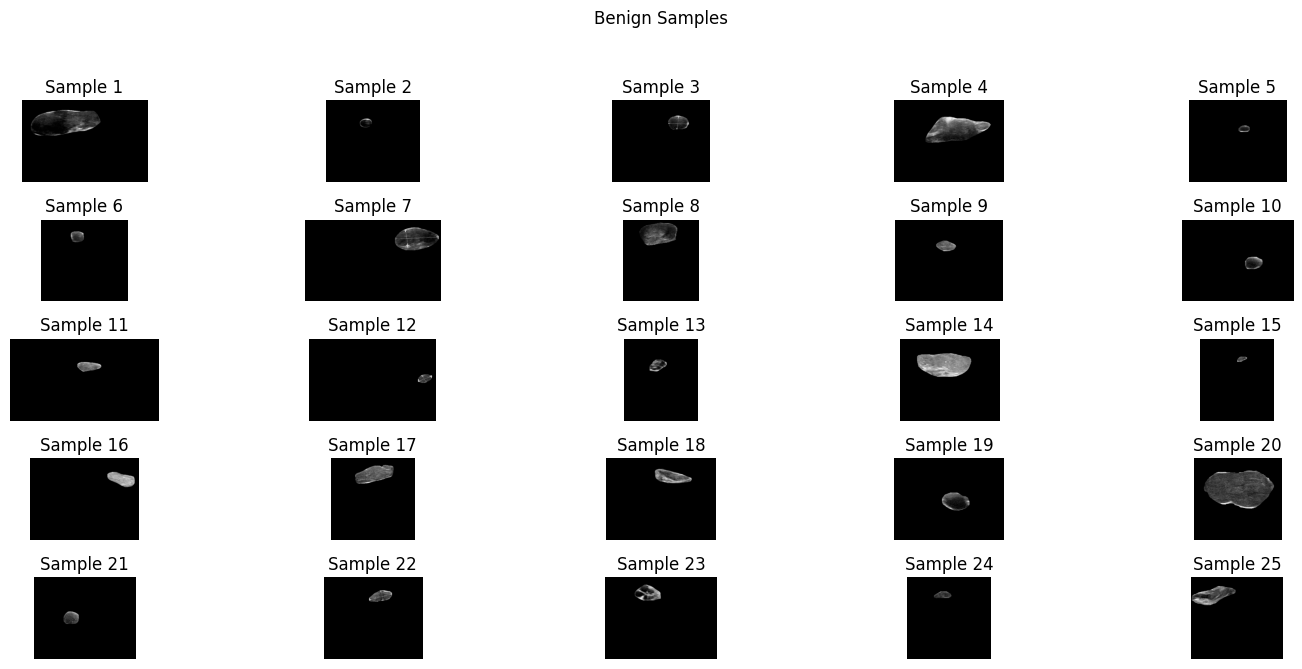

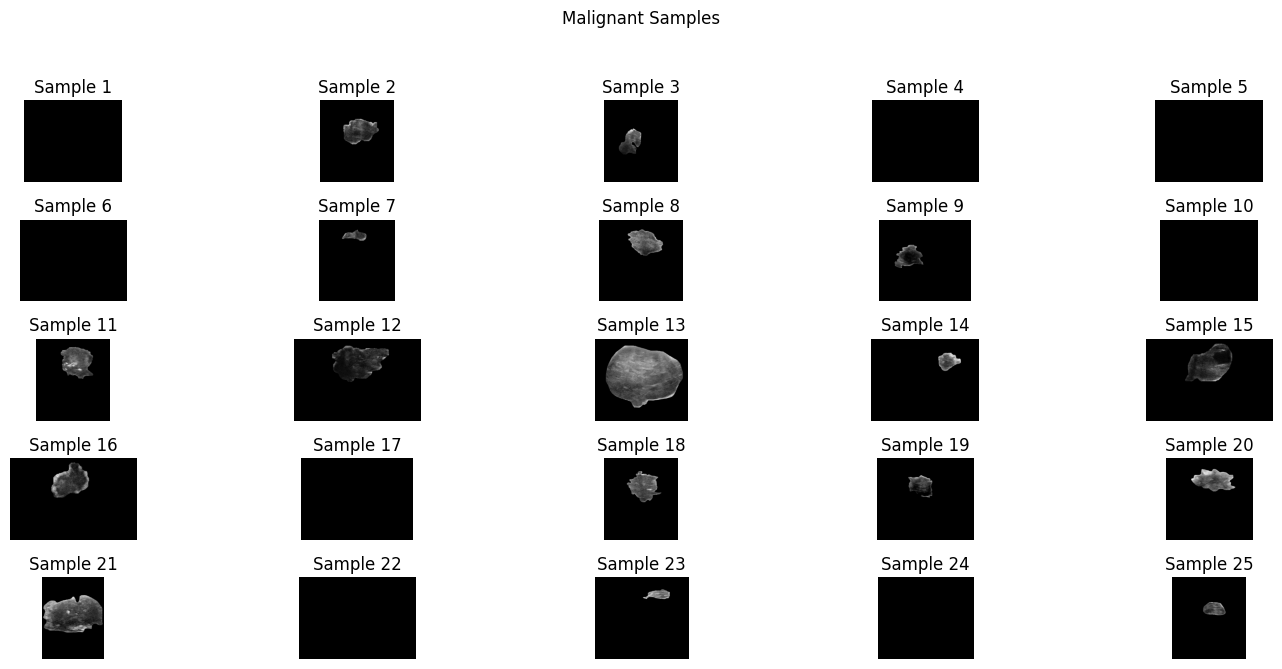

In [8]:
import matplotlib.pyplot as plt
import os
from PIL import Image

def plot_class_samples(base_path, class_name, num_samples=10):
    plt.figure(figsize=(15, 7))
    class_folder = os.path.join(base_path, class_name)
    image_files = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if f.endswith('.png')]

    for i in range(min(num_samples, len(image_files))):
        img_path = image_files[i]
        img = Image.open(img_path).convert('L')  # Load in grayscale
        ax = plt.subplot(5, 5, i + 1)  # Adjust subplot grid for 10 images: 2 rows and 5 columns
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Sample {i + 1}")
        ax.axis('off')

    plt.suptitle(f"{class_name.capitalize()} Samples")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

base_path = 'data/Ordered_images/'

plot_class_samples(base_path, 'benign', num_samples=25)

plot_class_samples(base_path, 'malignant', num_samples=25)

## Is there a class imbalance? 

In [58]:
combined_df['classification'].value_counts()

classification
benign       591
malignant    308
Name: count, dtype: int64

# Model building

## Loading data with keras.preprocessing function (tip from Vlad)

In [59]:
import tensorflow as tf

base_path = 'data/Ordered_images/'

# parameters for the dataset generation
batch_size = 32
img_height = 180  # what should the input size be? #224
img_width = 180   # ?

# Create training dataset from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    labels='inferred',
    label_mode='int',   # Labels are returned as integers
    class_names=['benign', 'malignant'], # class names
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),  # resize images to the specified size
    shuffle=True,        # shuffles the data
    seed=123,            # seed for shuffling and transformations
    validation_split=0.2,  # image proportion for validation
    subset='training',
)

# Crreating validation set
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    labels='inferred',
    label_mode='int',
    class_names=['benign', 'malignant'],
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)

Found 899 files belonging to 2 classes.
Using 720 files for training.
Found 899 files belonging to 2 classes.
Using 179 files for validation.


In [31]:
import numpy as np
# Convert dataset to a list of NumPy arrays
data_list = [{"feature1": item[0].numpy(), "feature2": item[1].numpy()} for item in dataset]

# Create a DataFrame from the list of NumPy arrays
#df = pd.DataFrame(data_list, columns=["Column_name"])  # Change "Column_name" to your desired column name
print(data_list)

2024-05-06 16:04:14.659893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[{'feature1': array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

  

## Data preprocessing and augmentation 

## Edge detection: is it true that benign lesions are rather round and malignant ones are rather irregularly shaped? 

## Inspect Preprocessed Images?

## Baseline model

In [60]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks


model = Sequential()

#model.add(layers.Rescaling(1./255, input_shape = (180,180,1)))
model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same", input_shape = (180,180,1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

model.add(layers.Flatten())

# Here we flatten our data to end up with just one dimension

model.add(layers.Dense(32, activation="relu"))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation="sigmoid"))

# And we perform the prediction using sigmoid

/home/juliane/.pyenv/versions/3.10.6/envs/breast_lesion_DL/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 180, 180, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 23, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,809 (2.64 MB)

 Trainable params: 691,809 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:

adam = optimizers.Adam(learning_rate = 0.01)
model.compile(loss='binary_crossentropy',
              optimizer= adam,
              metrics=['accuracy'])

In [63]:
MODEL = "model_baseline"

modelCheckpoint = callbacks.ModelCheckpoint("{}.keras".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.001, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)


In [64]:
%%time
history = model.fit(
        dataset,
        epochs=10,
        validation_data=validation_dataset,
        callbacks = [LRreducer, EarlyStopper],
        verbose = 1)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 913ms/step - accuracy: 0.6081 - loss: 8.8944 - val_accuracy: 0.7207 - val_loss: 0.6401 - learning_rate: 0.0100
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 648ms/step - accuracy: 0.6443 - loss: 0.6355 - val_accuracy: 0.7989 - val_loss: 0.5125 - learning_rate: 0.0100
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 816ms/step - accuracy: 0.6860 - loss: 0.6190 - val_accuracy: 0.7654 - val_loss: 0.4963 - learning_rate: 0.0100
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 718ms/step - accuracy: 0.7693 - loss: 0.5121 - val_accuracy: 0.7374 - val_loss: 0.5611 - learning_rate: 0.0100
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 775ms/step - accuracy: 0.7930 - loss: 0.4736 - val_accuracy: 0.7989 - val_loss: 0.4884 - learning_rate: 0.0100
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 700ms/step - accuracy: 0.8288 - loss: 0.4571 - val_accuracy: 0.8212 - val_loss: 0.4785 - learning_rate: 0.0100
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 684ms/step - accuracy: 0.8480 - loss: 0.

In [65]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

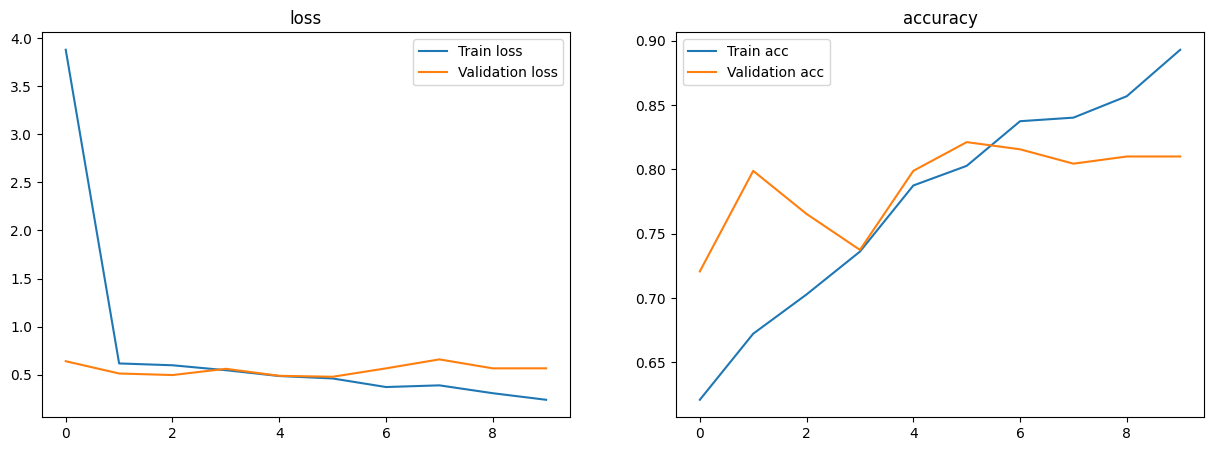

In [66]:
plot_history(history)